<a href="https://colab.research.google.com/github/ronandenyer/Mickey_Ninjas/blob/Time_Windows/Steinmetz_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting LFP data from pickled, pp'ed sets

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
import matplotlib.pyplot as plt
import scipy.signal as sp
import numpy as np
import pickle
!pip install mne

In [3]:
!pwd
!ls
%cd gdrive/MyDrive/repos/Mickey_Ninjas

/content
gdrive	sample_data
/content/gdrive/MyDrive/repos/Mickey_Ninjas


In [4]:
with open('filtered_LFP.pkl', 'rb') as f:
    filt_dat_LFP = pickle.load(f)

In [5]:
print(np.shape(filt_dat_LFP[10]['lfp']))

(8, 342, 250)


# Loading Steinmetz SPIKING data

In [6]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [7]:
#@title Data loading

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [8]:
# for each session, pull over the info from the spiking datasets to add to LFP
for isession in range(len(alldat)):
  # mouse name
  filt_dat_LFP[isession]['mouse_name'] = alldat[isession]['mouse_name']
  filt_dat_LFP[isession]['contrast_left'] = alldat[isession]['contrast_left']
  filt_dat_LFP[isession]['contrast_right'] = alldat[isession]['contrast_right']
  filt_dat_LFP[isession]['gocue'] = alldat[isession]['gocue']
  filt_dat_LFP[isession]['response'] = alldat[isession]['response']
  filt_dat_LFP[isession]['wheel'] = alldat[isession]['wheel']
  filt_dat_LFP[isession]['response_time'] = alldat[isession]['response_time']

# so as to not crash
del alldat

`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files. 

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 

Info added from spiking sets:
* `dat['mouse_name']`: mouse name
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




# Check which brain regions in which LFP dataset (Darcy)

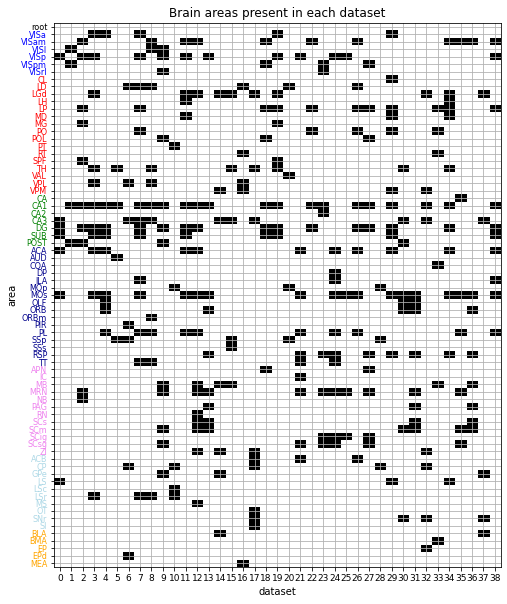

In [ ]:
# @title Make a plot of which brain areas are present in each dataset
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(filt_dat_LFP)), dtype=bool)
for j, d in enumerate(filt_dat_LFP):
    for area in np.unique(d['brain_area_lfp']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
    yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(filt_dat_LFP)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
    for area in group:
        ytickobjs[counter].set_color(color)
        counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)

# Time window code (Ronan), edited slightly for LFP data


In [ ]:
# function to loop through trial data and create 2 x 1 array describing the time
# point at which visual stimulus was displayed and a second event within the 
# trial (e.g. response, go cue onset). Option to keep units in seconds or change
# to 10ms time bin format used by spike data

def time_window_generator(start_window_variable, end_window_variable, spike_rate_format=True):
  '''
  Creates a time window on visual stim onset to later trial event

  Args:
    start_window_variable (float)               : fixed value for visual stim onset (s)
    end_window_variable (numpy array of floats) : array of second event times per trial (s)
    spike_rate_format (boolean)                 : boolean whether to calculate in 10ms bins
  
  Returns:
    numpy array of floats

  '''
  number_trials = len(end_window_variable) #loop through number of trials per session
  start_window = start_window_variable
  time_window = np.zeros([number_trials,2]) #initialize time_window variable
  print(np.shape(time_window))

  for trial in range(number_trials):

    time_window[trial] = np.array([start_window[trial], end_window_variable[trial]]).T * 100
    
    if spike_rate_format:
      time_window = np.round(time_window)


  return time_window

for session in range(len(filt_dat_LFP)):
  
  dat = filt_dat_LFP[session]
  dat['stim_response_time_window'] = time_window_generator(dat['gocue'], dat['response_time'])  
print(dat['stim_response_time_window'] )
# example plot of time windows on single trial
#plt.plot(filt_dat_LFP[0]['spks'][670][0])
#plt.axvline(filt_dat_LFP[0]['stim_response_time_window'][0][0], color='blue', linewidth=5, label = 'visual stim')
#plt.axvline(filt_dat_LFP[0]['stim_response_time_window'][0][1], color='red', linewidth=5, label='response')
#plt.axvline(filt_dat_LFP[0]['stim_gocue_time_window'][0][1], color='green', linewidth=5, label='GO cue')
#plt.legend()


In [ ]:
range(len(dat['response_time']))

range(0, 214)

In [ ]:
def compute_accuracy(data = filt_dat_LFP, session = list(np.arange(0, 39, 1))):
    """ 
    arguments:
    session: a list of session numbers to evaluate.  Default is all session in dat.
    
    output:
    accuracy: a session-length np.array of n-trial length arrays listing correct = 1, incorrect = 0
    accuracy_pct: a percentage score of correct vs. incorrect trials
    accuracy_move: a session-length np.array of arrays where movement was required
    accuracy_pct_move: a percentage score of correct vs. incorrect trials when movement was required
    indMove: index of trials where movement was supposed to happen within session
    ADDED:
    indCorrTrials: for each session, boolean of correct trials, 1 = corr, 0 = incorr
    """
    accuracy_all = []
    accuracy_move_all = []
    accuracy_bool_all = []
    accuracy_bool_move_all = []
    indMove_all = []
    indCorrTrials = []
    
    for i, run in enumerate(session):
        # get relevant data
        
        #set_trace()
        response = data[i]['response'] # right - nogo - left (-1, 0, 1)
        vis_right = data[i]['contrast_right'] # 0 - low - high
        vis_left = data[i]['contrast_left'] # 0 - low - high

        #initialize empty boolean accuracy object
        accuracy_bool = np.zeros(len(response))

        # the following are the correct responses:
        # if vis_left > vis_right : response >0
        # if vis_left < vis_right : response <0
        # if vis_left = vis_right : response =0
        # trials below red line are incorrect
        is_correct = np.sign(response)==np.sign(vis_left-vis_right)
        accuracy_bool[is_correct] = 1
        indCorrTrials = accuracy_bool
        accuracy = np.sum(accuracy_bool)/len(accuracy_bool)

        # Compute accuracy for only movement trials
        indMove = np.logical_or(vis_right > vis_left, vis_left > vis_right)

        # create vectors only of movement trials
        response_move = response[indMove]
        vis_right_move = vis_right[indMove]
        vis_left_move = vis_left[indMove]

        # compute accuracy only for movement trials
        accuracy_bool_move = np.zeros(len(response_move))

        is_correct_move = np.sign(response_move)==np.sign(vis_left_move - vis_right_move)
        accuracy_bool_move[is_correct_move] = 1
        accuracy_move = np.sum(accuracy_bool_move)/len(accuracy_bool_move)

        #set_trace()
        accuracy_all.append(accuracy)
        accuracy_move_all.append(accuracy_move)
        accuracy_bool_all.append(accuracy_bool)
        accuracy_bool_move_all.append(accuracy_bool_move)
        indMove_all.append(indMove)
        
    return([accuracy_all, accuracy_move_all, accuracy_bool_all, accuracy_bool_move_all, indMove, indCorrTrials])

accuracy_all, accuracy_move_all, accuracy_bool_all, accuracy_bool_move_all, indMove, indCorrTrials = compute_accuracy()

In [ ]:
print()

[0.6495327102803738, 0.601593625498008, 0.6140350877192983, 0.6706827309236948, 0.6181102362204725, 0.7068965517241379, 0.6428571428571429, 0.632, 0.6827956989247311, 0.610738255033557, 0.7631578947368421, 0.6941176470588235, 0.7666666666666667, 0.6753731343283582, 0.7400990099009901, 0.6964285714285714, 0.7946428571428571, 0.7626582278481012, 0.5870445344129555, 0.5702127659574469, 0.5564516129032258, 0.6531531531531531, 0.6622516556291391, 0.5614973262032086, 0.7049808429118773, 0.7247191011235955, 0.6403162055335968, 0.5915492957746479, 0.5859375, 0.48951048951048953, 0.6751054852320675, 0.7076923076923077, 0.6701570680628273, 0.5878378378378378, 0.7459807073954984, 0.7054263565891473, 0.7348066298342542, 0.6482412060301508, 0.717201166180758]


# Time-frequency conversion function using multitaper/welch from https://raphaelvallat.com/bandpower.html (but didn't actually end up using this approach...)

In [ ]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp


# Use on LFP data to extract beta time-locked to responses (Darcy, using some of Phil's acc code)

In [58]:
# target region
area_to_do = 'MOs' # change based on which to plot
#preassign
area_bool = np.zeros(len(filt_dat_LFP))
for isession in range(len(filt_dat_LFP)):
  if area_to_do in filt_dat_LFP[isession]['brain_area_lfp']:
    area_bool[isession] = 1
  else:
    area_bool[isession] = 0
area_sessions = np.sum(area_bool)

ALL_WINDOWS = np.zeros([int(area_sessions),11,16])
CORR_WINDOWS = np.zeros([int(area_sessions),11,16])
INCORR_WINDOWS = np.zeros([int(area_sessions),11,16])
area_counter = 0

# loop through sessions with that region in the recording
for isession in range(len(filt_dat_LFP)):

  if area_to_do in filt_dat_LFP[isession]['brain_area_lfp']:
    print('Area in session ' + str(isession))

    # get index of region channel in data
    brain_ind = filt_dat_LFP[isession]['brain_area_lfp'].index(area_to_do)

    # get correct trials in brain area of interest only
    response = filt_dat_LFP[isession]['response'] # right - nogo - left (-1, 0, 1)
    vis_right = filt_dat_LFP[isession]['contrast_right'] # 0 - low - high
    vis_left = filt_dat_LFP[isession]['contrast_left'] # 0 - low - high
    accuracy_bool = np.zeros(len(response))
    is_correct = np.sign(response)==np.sign(vis_left-vis_right)
    accuracy_bool[is_correct] = 1
    
    # get time indices of responses
    stim_response_times = np.round(filt_dat_LFP[isession]['response_time']*100)
    correct_response_times = [i for indx, i in enumerate(stim_response_times) if accuracy_bool[indx] == 1]
    incorrect_response_times = [i for indx, i in enumerate(stim_response_times) if accuracy_bool[indx] == 0]

    # initialize variable to save trial data
    correct_trial_windows = np.zeros([len(correct_response_times),11,16])
    incorrect_trial_windows = np.zeros([len(incorrect_response_times),11,16])
    cor = 0;
    incor = 0;

    trial_TF = np.zeros([np.shape(filt_dat_LFP[isession]['lfp'])[1],11,16])
    
    # iterate over trials
    for itrial in range(np.shape(filt_dat_LFP[isession]['lfp'])[1]):

      # grab bandpower of entire trial
      freqs, times, Sx =  sp.spectrogram(filt_dat_LFP[isession]['lfp'][brain_ind][itrial], fs=100, window='hanning',
                                      nperseg=20, noverlap=5,
                                      detrend=False, scaling='spectrum')
      trial_TF[itrial] = Sx
       
      # save each trial, grabbing window around response
      firstval = int(stim_response_times[itrial]+window_around_resp[0])
      secval = int(stim_response_times[itrial]+window_around_resp[1])
      if secval <= 250:
        if accuracy_bool[itrial] == 1:
          correct_trial_windows[cor] = trial_TF[itrial]
          cor += 1
        elif accuracy_bool[itrial] == 0:
          incorrect_trial_windows[incor] = trial_TF[itrial]
          incor += 1
    
    # save session data
    ALL_WINDOWS[area_counter] = np.mean(trial_TF,axis=0)
    CORR_WINDOWS[area_counter] = np.mean(correct_trial_windows,axis=0)
    INCORR_WINDOWS[area_counter] = np.mean(incorrect_trial_windows,axis=0)
    area_counter += 1

Area in session 0
Area in session 3
Area in session 4
Area in session 7
Area in session 11
Area in session 12
Area in session 13
Area in session 21
Area in session 24
Area in session 25
Area in session 26
Area in session 29
Area in session 30
Area in session 31
Area in session 34
Area in session 35
Area in session 36
Area in session 38


In [54]:
print(np.shape(ALL_WINDOWS))
print(ALL_WINDOWS[1])
#del(ALL_WINDOWS)

(3, 11, 16)
[[ 5.4145833   4.56073182  6.08889337 12.61732582 43.89620783 93.34885687
  83.02621075 45.40735741 48.44103651 62.86493066 76.21289515 79.33055043
  57.94129085 37.77886263 31.70613565 27.9581664 ]
 [13.03952229 12.52887679 13.3363784  16.75451357 39.29441565 55.52577272
  50.23482291 32.28531429 36.01757776 40.20306725 48.69414707 50.98532351
  39.75156085 26.63315499 25.61943394 21.6574885 ]
 [ 6.491696    7.42171823  7.9151548   6.14432345  7.6427725   6.66079101
   5.73315987  5.93905371  6.3637151   6.67226     6.15359058  6.54568447
   5.77317196  6.28373504  6.13390947  5.40934667]
 [ 3.49674881  3.40262971  4.14132139  3.78881837  3.67110338  3.60630534
   3.44637643  3.12176263  3.35018993  4.11699353  3.77428035  3.8144516
   3.08545145  4.01681313  3.52417528  2.90389268]
 [ 3.0778893   3.16523104  3.7295168   3.83489893  3.09185303  3.34154544
   3.13124458  3.07152064  3.42755446  3.85212211  3.15208067  3.2390348
   2.74310857  3.41907911  3.14782346  2.87373

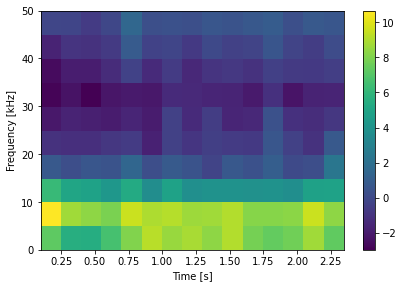

In [50]:
# example of TF plot from one session
f, ax = plt.subplots(figsize=(6.8, 4.4))
c = ax.pcolormesh(times, freqs, 10 * np.log10(np.mean(trial_TF,axis=0)), cmap='viridis')
plt.colorbar(c)
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

# Plot average ERSPs over all sessions

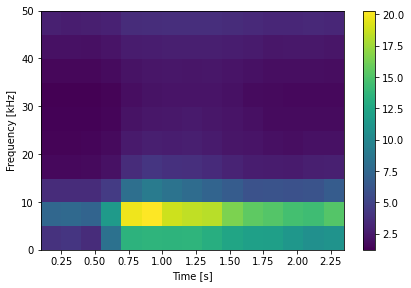

In [62]:
# all trials
f, ax = plt.subplots(figsize=(6.8, 4.4))
c = ax.pcolormesh(times, freqs, 10 * np.log10(np.mean(ALL_WINDOWS,axis=0)), cmap='viridis')
plt.colorbar(c)
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

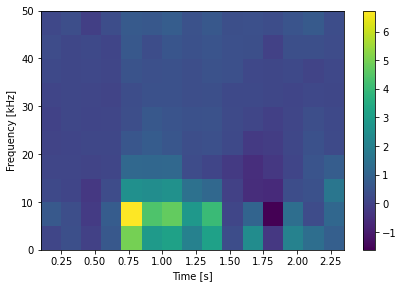

In [61]:
# difference between correct and incorrect trials
f, ax = plt.subplots(figsize=(6.8, 4.4))
c = ax.pcolormesh(times, freqs, 10 * np.log10(np.mean(CORR_WINDOWS,axis=0)-np.mean(INCORR_WINDOWS,axis=0)), cmap='viridis')
plt.colorbar(c)
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');